
### Blood Smear MODEL


---

Imports 

---


In [6]:
import importlib
import pipeline as pl
importlib.reload(pl)
import model as ml
importlib.reload(ml)

import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import keras_tuner
from kerastuner.tuners import Hyperband

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.19.0


---

Load Augmented data from pipeline

---

In [7]:
csv_path = "BloodSmear.csv"
train, test,val = pl.loadprocesseddata(csv_path)

Found 15000 validated image filenames belonging to 4 classes.
Found 2500 validated image filenames belonging to 4 classes.
Found 2500 validated image filenames belonging to 4 classes.


---

Build Model

---

In [8]:
def build_cnn_model(hp, n_classes=4):
    activation = hp.Choice("activation", values=["relu", "tanh", "elu"])
    n_conv_layers = hp.Int("n_conv_layers", min_value=2, max_value=5, step=1)
    n_filters = hp.Int("n_filters", min_value=8, max_value=64, step=8)
    
    kernel_size_val = hp.Choice("kernel_size", values=[3, 5])
    pool_size_val = hp.Choice("pool_size", values=[2, 3])
    
    learning_rate = hp.Float("learning_rate", min_value=1e-5, max_value=1e-2, sampling="log")
    decay_steps = hp.Int("decay_steps", min_value=1000, max_value=10000, step=1000)
    decay_rate = hp.Float("decay_rate", min_value=0.9, max_value=0.999, step=0.001)
    dropout_rate = hp.Float("dropout_rate", min_value=0.2, max_value=0.5, step=0.1)
    batch_norm = hp.Choice("batch_norm", values=[True, False])
    optimizer_choice = hp.Choice("optimizer", values=["sgd", "RMSprop", "adam", "AdamW"])
    
    expon_dec = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate
    )
    if optimizer_choice == "sgd":
        optimizer = keras.optimizers.SGD(learning_rate=expon_dec)
    elif optimizer_choice == "RMSprop":
        optimizer = keras.optimizers.RMSprop(learning_rate=expon_dec)
    else:
        optimizer = keras.optimizers.Adam(learning_rate=expon_dec)
    
    model = keras.Sequential()
    
    model.add(layers.Conv2D(
        filters=n_filters,
        kernel_size=(kernel_size_val, kernel_size_val),
        activation=activation,
        input_shape=(64, 64, 3),
        padding='same'
    ))
    if batch_norm:
        model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(pool_size_val, pool_size_val)))
    
    for i in range(n_conv_layers - 1):
        model.add(layers.Conv2D(
            filters=n_filters * (2**i),
            kernel_size=(kernel_size_val, kernel_size_val),
            activation=activation,
            padding='same'
        ))
        if batch_norm:
            model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(pool_size_val, pool_size_val)))
        model.add(layers.Dropout(dropout_rate))

    model.add(layers.GlobalAveragePooling2D())
    
    n_dense_units = hp.Int("n_dense_units", min_value=32, max_value=256, step=32)
    model.add(layers.Dense(units=n_dense_units, activation=activation))
    if batch_norm:
        model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Dense(n_classes, activation="softmax"))
    
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
    return model


---

Hyperband Search

---

In [9]:
tuner = Hyperband(
    lambda hp: build_cnn_model(hp),
    objective='val_accuracy',
    max_epochs=15,
    factor=3,
    directory='hyperbanding-ScanTypes',
    project_name='Blood')

c:\Users\ckell\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
tuner.search(train, epochs=10, validation_data=val)

Trial 24 Complete [00h 12m 03s]
val_accuracy: 0.39719998836517334

Best val_accuracy So Far: 0.9944000244140625
Total elapsed time: 01h 41m 54s


In [11]:
best_model = tuner.get_best_models(num_models=1)[0]

c:\Users\ckell\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 1 variables whereas the saved optimizer has 21 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


---

Train Best Model

---

In [12]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=25,
    restore_best_weights=True)

In [13]:
history = best_model.fit(
    train,
    epochs=200,
    validation_data=val,
    callbacks=[early_stopping])

Epoch 1/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 54s 112ms/step - accuracy: 0.9757 - loss: 0.0739 - val_accuracy: 0.9776 - val_loss: 0.0624
Epoch 2/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 52s 111ms/step - accuracy: 0.9792 - loss: 0.0628 - val_accuracy: 0.9852 - val_loss: 0.0496
Epoch 3/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 52s 110ms/step - accuracy: 0.9806 - loss: 0.0532 - val_accuracy: 0.9916 - val_loss: 0.0266
Epoch 4/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 52s 110ms/step - accuracy: 0.9842 - loss: 0.0472 - val_accuracy: 0.9792 - val_loss: 0.0622
Epoch 5/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 53s 112ms/step - accuracy: 0.9810 - loss: 0.0507 - val_accuracy: 0.9820 - val_loss: 0.0499
Epoch 6/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 52s 110ms/step - accuracy: 0.9895 - loss: 0.0317 - val_accuracy: 0.9864 - val_loss: 0.0339
Epoch 7/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 53s 112ms/step - accuracy: 0.9893 - loss: 0.0287 - val_accuracy: 0.9712 - val_loss: 0.0658
Epoch 8/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 53s 112ms/step - accuracy: 0.9842 -

---

Plot Learning Curve

---

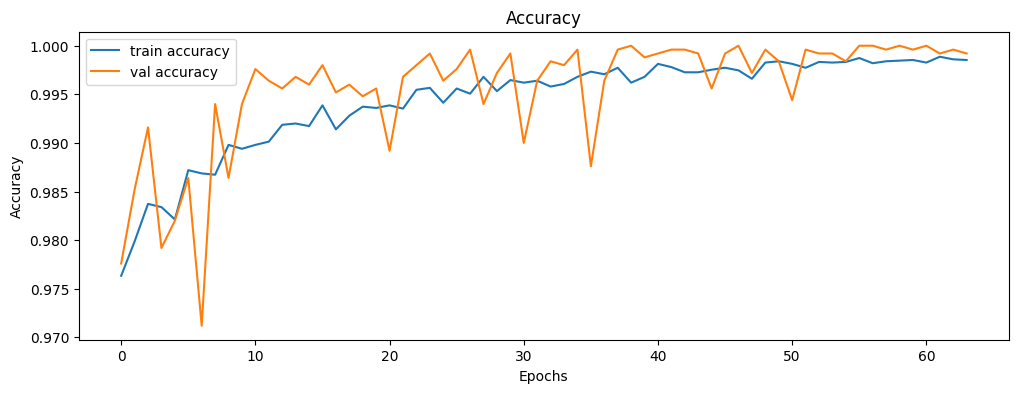

In [14]:
plt.figure(figsize=(12, 4))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

---

Obtain Val Accuracy

---

In [ ]:
results = best_model.evaluate(val, verbose=1)
print(f"Metrics: {results[1:]}")


79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.9996 - loss: 0.0018
Metrics: [0.9995999932289124]


---

Save Model

---

In [17]:
best_model.save('Blood Smear.keras')
